# Spectrograms Exploration

## Spectrograms

Spectrograms are a valuable tool in the field of gravitational wave analysis. They provide a visual representation of the frequency content of a signal over time, allowing researchers to identify and analyze specific features and patterns. By converting the time-domain signal into the frequency-domain, spectrograms enable the detection of gravitational wave signals embedded in noisy data. These spectrograms help researchers understand the characteristics of gravitational wave sources, such as their frequency evolution and duration. With the aid of spectrograms, scientists can extract valuable information from gravitational wave signals.

As shown in `prelim.ipynb`, spectrograms can be created from real data from GWOSC:

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/gwpy/plot/plot.py:287: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  super().show(warn=warn)


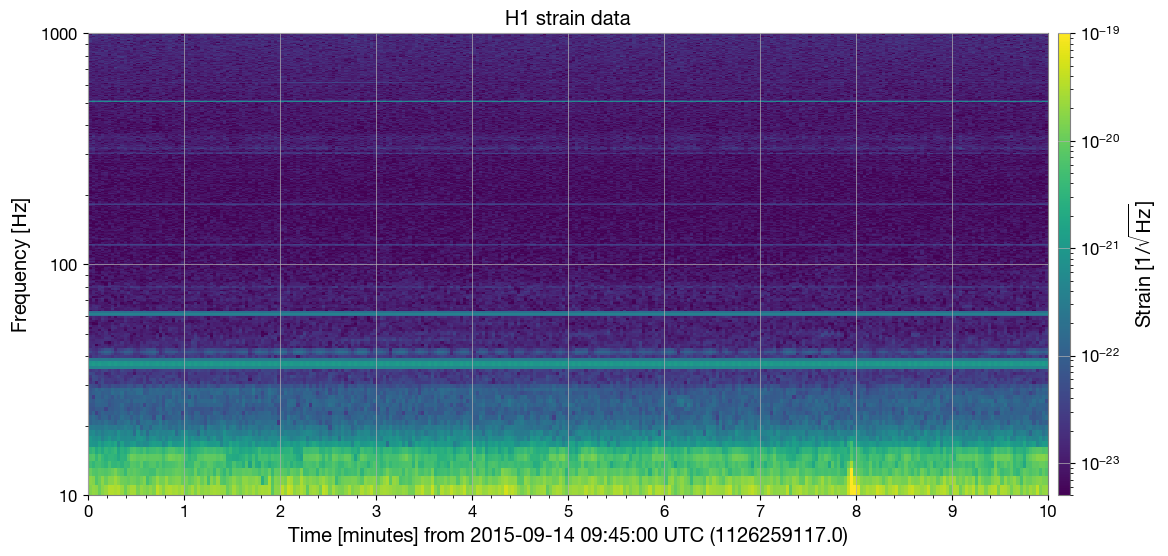

In [2]:
from gwpy.timeseries import TimeSeries
from gwpy.plot import Plot

detector_data = TimeSeries.fetch_open_data('H1', 1126259117, 1126259717)

def plot_spectrogram(data, interval, fftlength):
    spectrogram = data.spectrogram(interval, fftlength, overlap=15 * fftlength / (fftlength ** 2)) ** 0.5
    
    plot = spectrogram.imshow(norm='log', vmin=5e-24, vmax=1e-19, aspect='auto')
    axes = plot.gca()
    axes.set_yscale('log')
    axes.set_ylim(10, 1000)
    axes.colorbar(
        label=r'Strain [1/$\sqrt{\mathrm{Hz}}$]'
    )
    axes.set_title('H1 strain data')
    plot.show()

plot_spectrogram(detector_data, 2, 1)

With spectrograms, there's a tradeoff between the time and frequency resolutions; it can be found that $\Delta t \Delta f \approx 1$. With smaller sampling times, frequencies cannot be determined with as high of specificity, meaning they are put into broader bins:

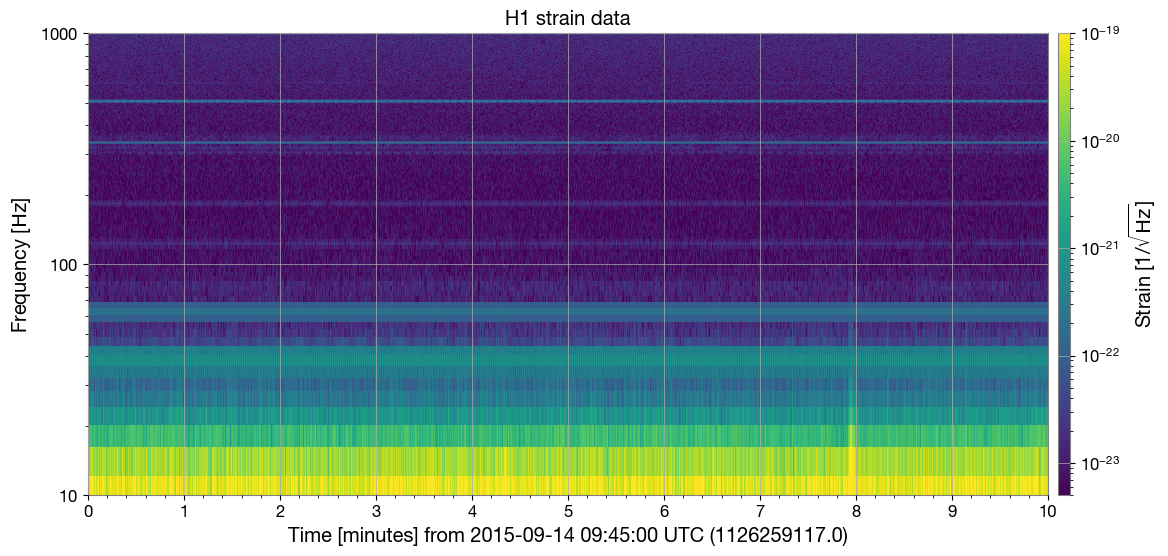

In [3]:
plot_spectrogram(detector_data, 0.5, 0.25)

Conversely, larger sampling times allow frequencies to be discirned with a higher level of specificity. However, this also means it's harder to determine exactly when those frequencies are occuring, due to the decreased time resolution.

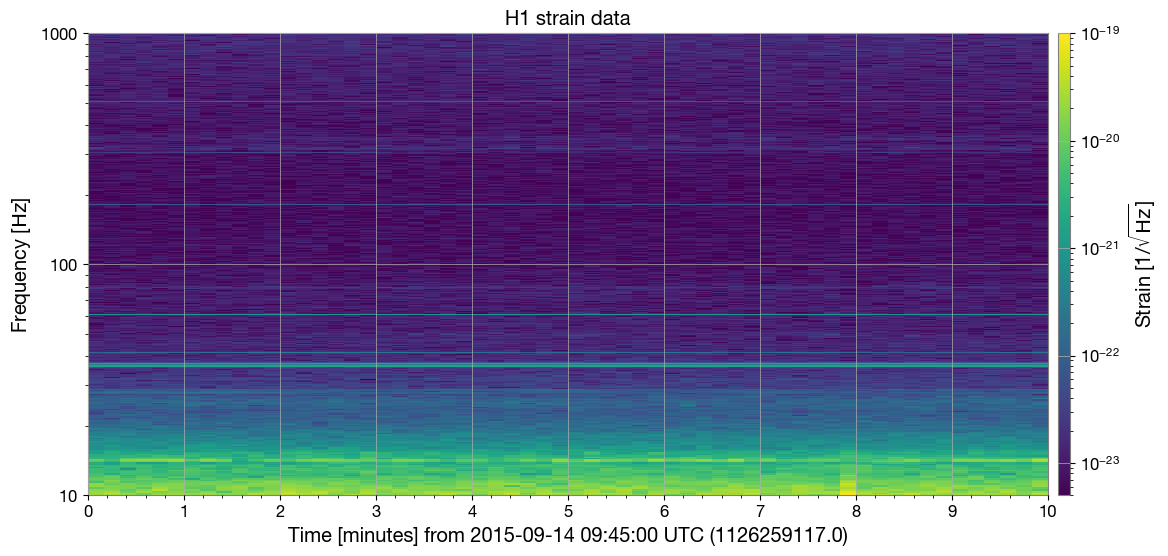

In [4]:
plot_spectrogram(detector_data, 10, 5)

The data can be normalized by average strain for each frequency, making it a bit easier to see through the noise. This can be done by dividing each value by the average value for that frequency.

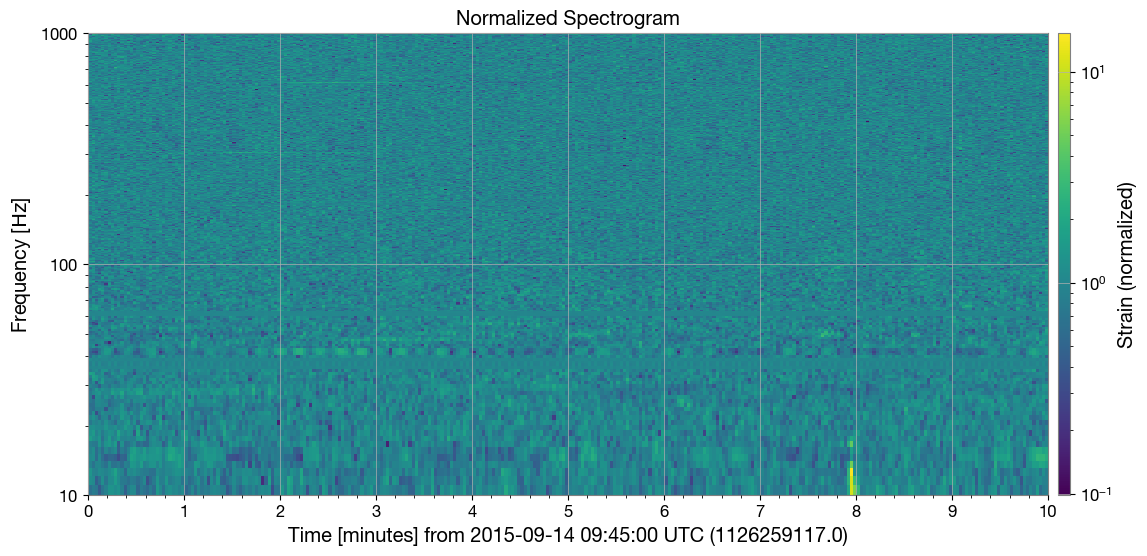

In [19]:
def generate_normalized_spectrogram(data, interval, fftlength):
    spectrogram = data.spectrogram(interval, fftlength, overlap=fftlength / 2) ** 0.5
    normalized_spectrogram = spectrogram / spectrogram.mean(axis=0)
    
    plot = normalized_spectrogram.imshow(norm='log', aspect='auto')
    axes = plot.gca()
    axes.set_yscale('log')
    axes.set_ylim(10, 1000)
    axes.colorbar(
        label='Strain (normalized)'
    )
    axes.set_title('Normalized Spectrogram')

generate_normalized_spectrogram(detector_data, 2, 1)

## Searching for a signal

The first step in searching for a signal is to limit the time-frame of a signal, since they happen over very short periods of time.

Fetched 1 URLs from gwosc.org for [1126259458 .. 1126259467))
Reading data... [Done]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/gwpy/plot/plot.py:287: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  super().show(warn=warn)


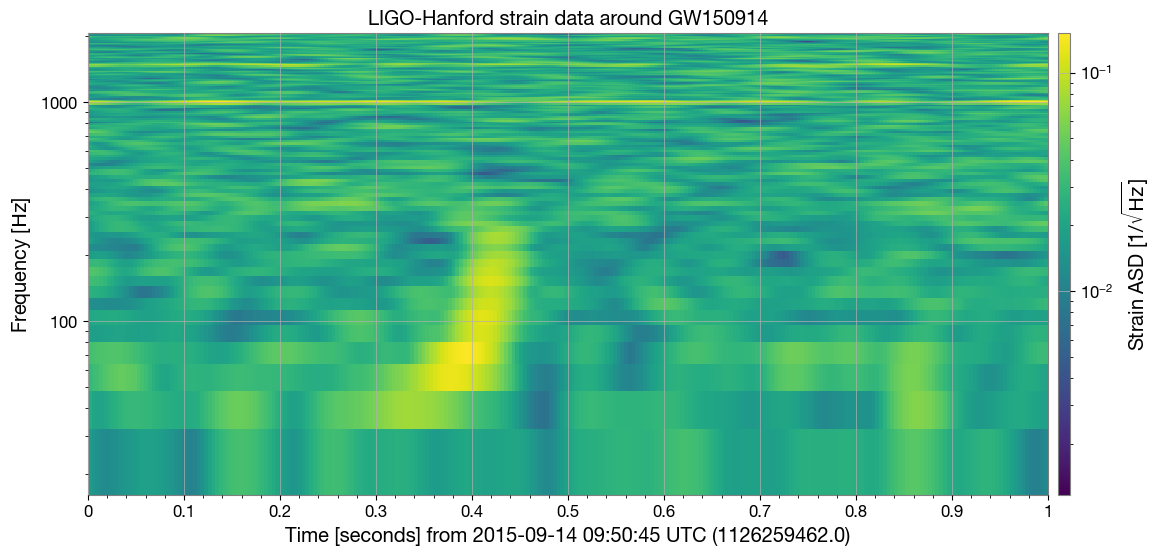

In [1]:
from gwpy.timeseries import TimeSeries

data = TimeSeries.fetch_open_data('H1', 1126259458, 1126259467, verbose=True)

# Using a high-pass filter and whitening to remove low-frequency noise and
# enhance low-amplitude signals in the middle of the frequency band
# 2 seconds on either end are cropped to remove artifacts from filtering
white_hp_data = data.highpass(20).whiten(4, 2).crop(1126259460, 1126259465)

spectrogram = white_hp_data.spectrogram2(fftlength=1/16., overlap=15/256.) ** (1/2.)
spectrogram = spectrogram.crop_frequencies(20)  # drop everything below highpass

plot = spectrogram.plot(norm='log', cmap='viridis', yscale='log')
ax = plot.gca()
ax.set_title('LIGO-Hanford strain data around GW150914')
ax.set_xlim(1126259462, 1126259463)
ax.colorbar(label=r'Strain ASD [1/$\sqrt{\mathrm{Hz}}$]')
plot.show()
